# Imports

In [8]:
# General Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV # For finding optimal solutions
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit # Setting up Test/Train split
from sklearn import metrics # For finding accuracy scores
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, zero_one_loss # For precision/recall scores
from sklearn.utils.multiclass import unique_labels # Needed for plot_confusion_matrix()
from sklearn.neural_network import MLPClassifier

# Models
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree

# Important Settings
np.set_printoptions(precision=2, threshold=2)

In [9]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.clf()
    plt.rcParams['figure.figsize'] = [15, 15] # Make matplot charts big enough to see

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    ax.grid(linestyle='-', linewidth='0.25', color='black')
    fig.tight_layout()
    return ax

# Data Cleaning

In [10]:
# Read Dataset
df = pd.read_csv("crime.csv")

# Set formatting to be consistent for offense codes
df['OFFENSE_CODE_GROUP'] = \
    df['OFFENSE_CODE_GROUP'].apply(lambda x: x.capitalize())

# Remap SHOOTING to not use Y / Null values
df['SHOOTING'] = df['SHOOTING'].apply(lambda x: 0 if x=='Y' else 1)

# Drop Lat/Long columns, and recreate from Location
df.drop(columns=['Lat','Long'], inplace=True)
df['LATITUDE'] = df['Location'].apply(lambda x: float(x[1:-1].split(', ')[0]))
df['LONGITUDE'] = df['Location'].apply(lambda x: float(x[1:-1].split(', ')[1]))
df.drop(columns=['Location'], inplace=True)

# One Hot Encode Day Of Week
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].apply(lambda x: x.upper())
ohe_dow = pd.get_dummies(df['DAY_OF_WEEK'],prefix='DOW')
df = pd.concat([df, ohe_dow], axis=1, sort=False)
df.drop(columns=['DAY_OF_WEEK'], inplace=True)

# One Hot Encode District
ohe_dist = pd.get_dummies(df['DISTRICT'],prefix='DIST')
df = pd.concat([df, ohe_dist], axis=1, sort=False)
df.drop(columns=['DISTRICT'], inplace=True)

df.dropna(subset=['UCR_PART'],inplace=True)

print(df.head())

  INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      I182070945           619               Larceny    LARCENY ALL OTHERS   
1      I182070943          1402             Vandalism             VANDALISM   
2      I182070941          3410                 Towed   TOWED MOTOR VEHICLE   
3      I182070940          3114  Investigate property  INVESTIGATE PROPERTY   
4      I182070938          3114  Investigate property  INVESTIGATE PROPERTY   

  REPORTING_AREA  SHOOTING OCCURRED_ON_DATE  YEAR  MONTH  HOUR  ... DIST_A7  \
0            808         1   9/2/2018 13:00  2018      9    13  ...       0   
1            347         1   8/21/2018 0:00  2018      8     0  ...       0   
2            151         1   9/3/2018 19:27  2018      9    19  ...       0   
3            272         1   9/3/2018 21:16  2018      9    21  ...       0   
4            421         1   9/3/2018 21:05  2018      9    21  ...       0   

  DIST_B2  DIST_B3  DIST_C11  DIST_C6  DIST_D14  D

In [11]:
# Dropping class values with less than n instances
n = 10
df_drop_class = df.groupby(['OFFENSE_CODE_GROUP']).count()['OFFENSE_CODE'].reset_index()
drop_class = df_drop_class[df_drop_class['OFFENSE_CODE'] < n]['OFFENSE_CODE_GROUP'].tolist()

print("Dropping Class Values:")
print(drop_class)

df = df[~df['OFFENSE_CODE_GROUP'].isin(drop_class)]
print(f'Now {len(df["OFFENSE_CODE_GROUP"].unique().tolist())} unique classes')

Dropping Class Values:
['Biological threat', 'Burglary - no property taken', 'Gambling', 'Manslaughter']
Now 59 unique classes


In [12]:
all_cols = list(df.columns.values)
day_cols = [x for x in all_cols if 'DOW_' in x]

# Get list of parameters for training
x_list = ['SHOOTING','LATITUDE','LONGITUDE','HOUR']
x_list.extend(day_cols)


x = df[x_list]
y = df['OFFENSE_CODE_GROUP'] #Can also be UCR_PART


# 0R Test

In [13]:
mode_df = df.groupby(['OFFENSE_CODE_GROUP']).count().sort_values('SHOOTING').tail(1)['LONGITUDE'].reset_index() 
mode_df.rename(columns={'LONGITUDE':'COUNT'}, inplace=True)
    
max_cnt = mode_df['COUNT'].tolist()[0]
tot_cnt = df.count()['OFFENSE_CODE_GROUP']

print(mode_df)
print('No Skill Test: {:.4f}%'.format(max_cnt/tot_cnt*100))

print(df.columns)

                OFFENSE_CODE_GROUP  COUNT
0  Motor vehicle accident response  37132
No Skill Test: 11.6415%
Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'REPORTING_AREA', 'SHOOTING', 'OCCURRED_ON_DATE',
       'YEAR', 'MONTH', 'HOUR', 'UCR_PART', 'STREET', 'LATITUDE', 'LONGITUDE',
       'DOW_FRIDAY', 'DOW_MONDAY', 'DOW_SATURDAY', 'DOW_SUNDAY',
       'DOW_THURSDAY', 'DOW_TUESDAY', 'DOW_WEDNESDAY', 'DIST_A1', 'DIST_A15',
       'DIST_A7', 'DIST_B2', 'DIST_B3', 'DIST_C11', 'DIST_C6', 'DIST_D14',
       'DIST_D4', 'DIST_E13', 'DIST_E18', 'DIST_E5'],
      dtype='object')


# DECISION TREE
## Find Best Parameters

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, stratify=y)
model = tree.DecisionTreeClassifier()

parameter_space = {
    'criterion': ['entropy','gini'],
    'max_depth': [x for x in range(1,60)],
    'splitter': ['best','random']
}
clf = GridSearchCV(model, parameter_space, scoring=make_scorer(metrics.accuracy_score), n_jobs=-1, cv=3)
clf.fit(x_train, y_train)

print(f'Best parameters found:\n {clf.best_params_}\n {clf.best_score_}')

Best parameters found:
 {'criterion': 'gini', 'max_depth': 14, 'splitter': 'best'}
 0.16551623235812035


## Fit Decision Tree

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, stratify=y)
clf = tree.DecisionTreeClassifier(criterion='gini',max_depth=11, splitter='best')

clf = clf.fit(x, y)
y_pred = clf.predict(x_test)

## Report Values

Results on the test set:


/Users/hunterboles/pyenv/py3-csci347-proj/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                  precision    recall  f1-score   support

              Aggravated assault       0.50      0.06      0.11      3123
                        Aircraft       1.00      0.29      0.44        14
                           Arson       1.00      0.03      0.05        38
Assembly or gathering violations       0.47      0.34      0.40       382
                      Auto theft       0.20      0.01      0.02      1940
             Auto theft recovery       0.83      0.01      0.02       420
                      Ballistics       0.21      0.02      0.04       392
                       Bomb hoax       0.00      0.00      0.00        30
             Commercial burglary       0.29      0.00      0.01       535
                Confidence games       0.09      0.01      0.01      1259
                  Counterfeiting       0.18      0.01      0.01       582
             Criminal harassment       0.00      0.00      0.00        52
              Disorderly conduct     

<Figure size 432x288 with 0 Axes>

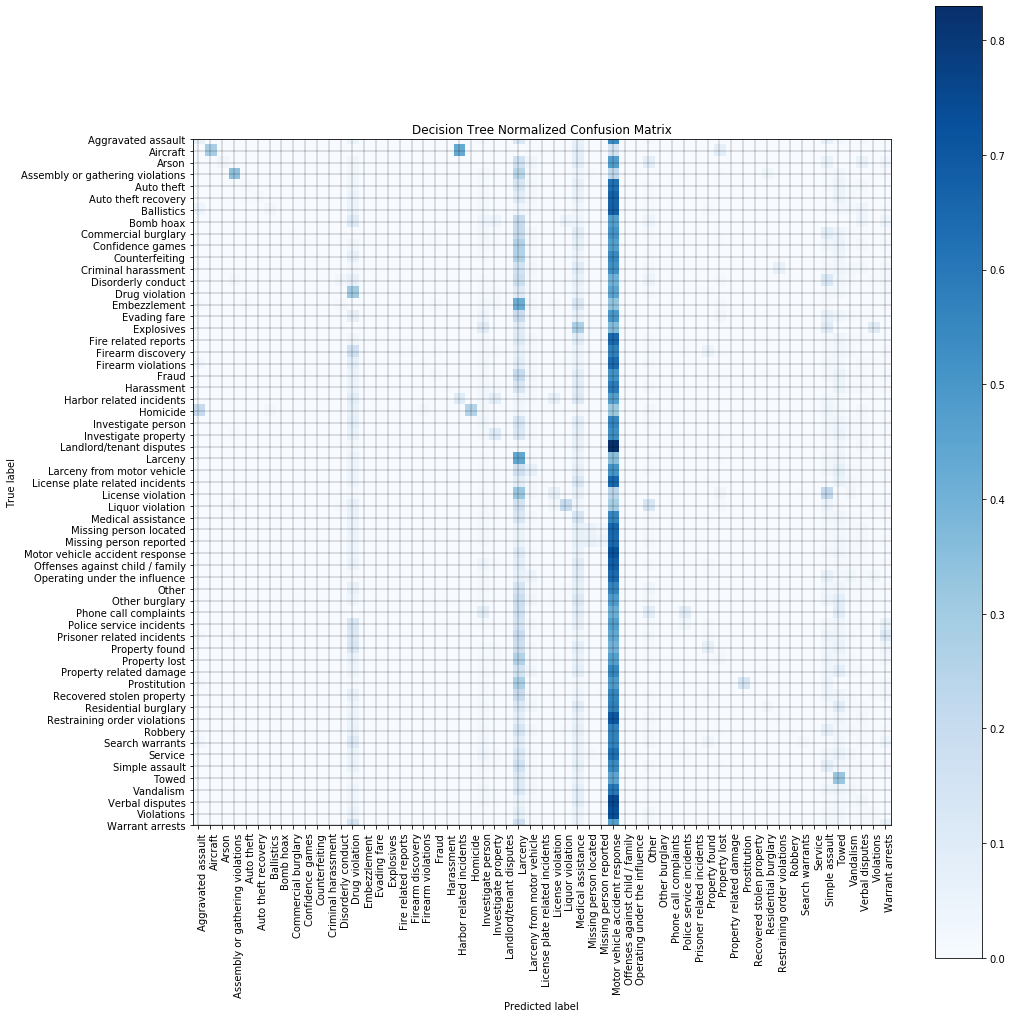

In [16]:
# Report accuracy
print('Results on the test set:')
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True, title="Decision Tree Normalized Confusion Matrix")
plt.savefig("Confusion_Decision_Tree.png")

# RANDOM FOREST
## Find Best Parameters

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, stratify=y)
model = RandomForestClassifier()

parameter_space = {
    'criterion': ['entropy','gini'],
    'max_depth': [x for x in range(1,30)],
    'n_estimators': [10,50,100]
}

clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_train, y_train)
print(f'Best parameters found:\n {clf.best_params_}\n {clf.best_score_}')

Best parameters found:
 {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 100}
 0.16893879619808022


## Fit Random Forest

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, stratify=y)
clf = RandomForestClassifier(max_depth=15, criterion='gini', n_estimators=100)

clf = clf.fit(x, y)
y_pred = clf.predict(x_test)

## Report Values

Results on the test set:
0.26121988305926985


/Users/hunterboles/pyenv/py3-csci347-proj/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                  precision    recall  f1-score   support

              Aggravated assault       0.73      0.10      0.18      3123
                        Aircraft       0.82      0.64      0.72        14
                           Arson       1.00      0.03      0.05        38
Assembly or gathering violations       0.65      0.43      0.52       382
                      Auto theft       0.79      0.02      0.04      1940
             Auto theft recovery       0.90      0.02      0.04       420
                      Ballistics       1.00      0.01      0.02       392
                       Bomb hoax       0.00      0.00      0.00        30
             Commercial burglary       0.84      0.04      0.07       535
                Confidence games       0.75      0.04      0.07      1259
                  Counterfeiting       0.88      0.01      0.02       582
             Criminal harassment       0.00      0.00      0.00        52
              Disorderly conduct     

<Figure size 1080x1080 with 0 Axes>

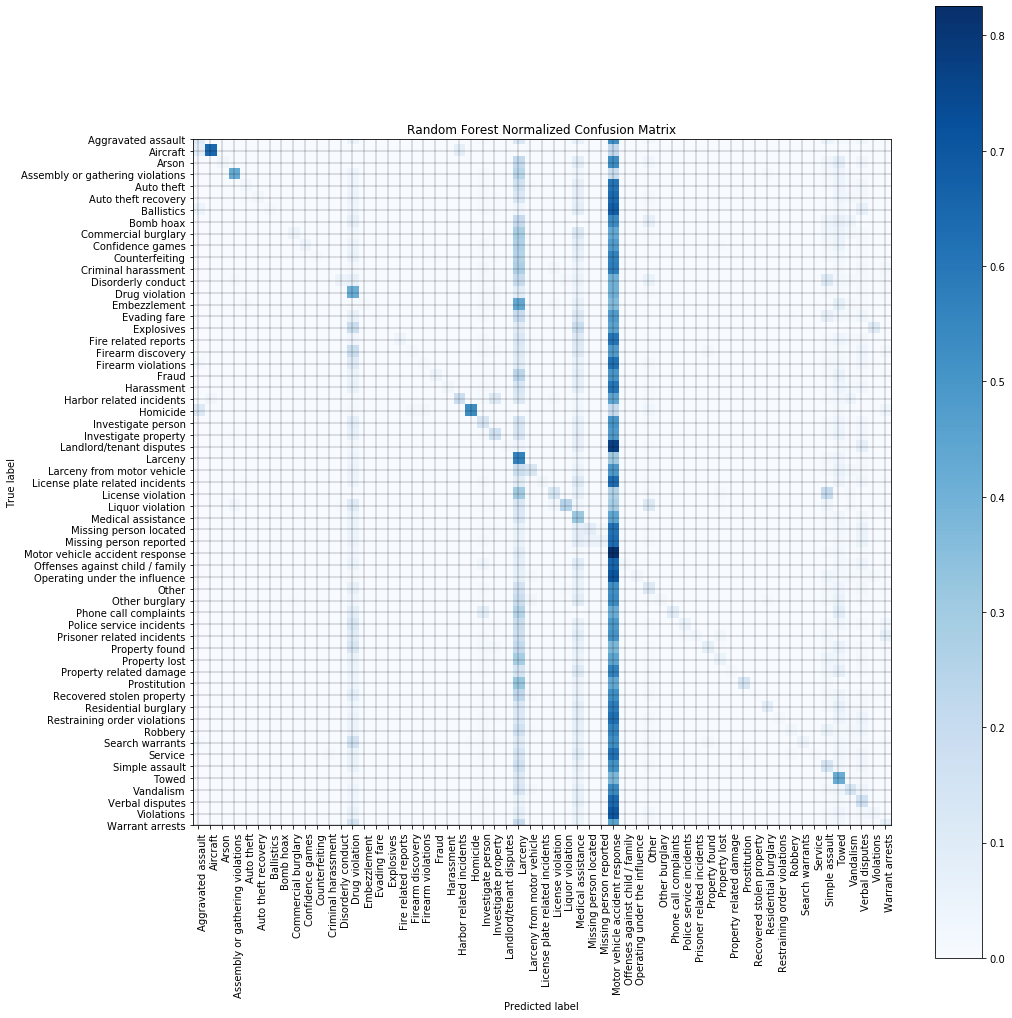

In [24]:
# Report Accuracy
print('Results on the test set:')
print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True, title="Random Forest Normalized Confusion Matrix")
plt.savefig("Confusion_Random_Forest.png")

# XGBOOST

## Build weighting array to balance the dataset

In [25]:
from sklearn.utils import class_weight

def get_weights(y_train):
    class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train))
    w_array = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(class_weights):
        w_array[i] = val
    return w_array

## Find Best Parameters

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, stratify=y)
model = XGBClassifier(n_jobs=-1, objective='multi:softmax',metric='merror')

parameter_space = {
    'max_depth': [4,6,8,10],
    'learning_rate': [.01,.05,.1,.2,.3],
}

clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_train, y_train, sample_weight=get_weights(y_train))
print(f'Best parameters found:\n {clf.best_params_}\n {clf.best_score_}')

KeyboardInterrupt: 

## Fit XGBoost

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, stratify=y)

model = XGBClassifier(n_jobs=-1, objective='multi:softmax', metric='merror', max_depth=10, learning_rate=.1)
model.fit(x_train, y_train, sample_weight=get_weights(y_train))

y_pred = model.predict(x_test)

## Report Values

In [ ]:
print('Results on the test set:')
print(model.score(x_test,y_test))

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model, num_trees=4, ax=ax)
plt.show()
plt.savefig("XGBoost_Tree.pdf")

# Multi Layered Perceptron Neural Network

## Find Best Parameters

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, stratify=y)
model = MLPClassifier(max_iter=100)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_train, y_train)
print(f'Best parameters found:\n {clf.best_params_}\n {clf.best_score_}')

## Fit Neural Network

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, stratify=y)

clf = MLPClassifier(max_iter=100)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

## Report Values

In [ ]:
# Report Accuracy
print('Results on the test set:')
print(classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))